In [2]:
# convert serial dates to datetime object
import os
import datetime 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
from PIL import Image

#sentiment analysis
from textblob import TextBlob
from sklearn.feature_extraction import text 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
from nltk.tokenize import word_tokenize 
from nltk import pos_tag, bigrams, FreqDist, ne_chunk

In [2]:
#pip install vaderSentiment

## Sentiment Analysis

### The aim is to provide the top uni-bi-tri grams to Airbnb Product Management team 
### To allow them to dive deep into consumer sentiments and what motivates the high ratings shown in the Tableau Story as well. 

In [4]:
review = pd.read_csv('airbnb_bi_project_reviews.csv')

In [5]:
print('Number of unique listings in Sentiment Analysis "review" data:',len(review['listing_id'].unique()))
print('Number of reviews', review.shape[0])
review.head()

Number of unique listings in Sentiment Analysis "review" data: 3191
Number of reviews 84849


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [6]:
# Number of missing rows
print('%2d missing rows in comments field' %review['comments'].isna().sum())

18 missing rows in comments field


In [7]:
#exclude missing comments
review = review.dropna(subset =['comments'],how='any')
review.shape[0]

84831

In [12]:
#Remove 'This is an automated posting'
def rowContainsAutomatedMessage(row):
    return "This is an automated posting" in row

review['automated_posting'] = review['comments'].apply(rowContainsAutomatedMessage)

auto_posting = review[review['automated_posting']==True]
print('Number of auto comments:', auto_posting.shape[0])

Number of auto comments: 796


In [13]:
review = review[review['automated_posting']==False]
print('Actual reviews:', review.shape[0])

Actual reviews: 84035


In [14]:
def getTBSubjectivity(row):
    return TextBlob(row).sentiment.subjectivity

def getTBPolarity(row):
    return TextBlob(row).sentiment.polarity

def getVDPolarity(row):
    return analyzer.polarity_scores(row)['compound']

analyzer = SentimentIntensityAnalyzer()
review['review subjectivity Textblob'] = review['comments'].apply(getTBSubjectivity)
review['review polarity Textblob'] = review['comments'].apply(getTBPolarity)
review['review polarity Vader'] = review['comments'].apply(getVDPolarity)
review['Average Polarity'] = (review['review polarity Vader'] + review['review polarity Textblob']) / 2

review['review Sentiment Textblob'] = np.where(review['review polarity Textblob']>= 0.01, 1, (np.where(review['review polarity Textblob']<= -0.01, -1, 0)))

review['review Sentiment Vader'] = np.where(review['review polarity Vader']>= 0.05, 1, (np.where(review['review polarity Vader']<=-0.05, -1, 0)))

print(review['review Sentiment Textblob'].value_counts())
print(review['review Sentiment Vader'].value_counts())


 1    82711
 0      961
-1      363
Name: review Sentiment Textblob, dtype: int64
 1    82524
 0      791
-1      720
Name: review Sentiment Vader, dtype: int64


In [15]:
review['Sentiment (lexicon)'] = np.where(review['Average Polarity']>0, 'Positive',\
                                   (np.where(review['Average Polarity']<0, 'Negative','Neutral')))
print('Combined sentiment from both methods:\n',review['Sentiment (lexicon)'].value_counts())

Combined sentiment from both methods:
 Positive    82819
Negative      682
Neutral       534
Name: Sentiment (lexicon), dtype: int64


In [16]:
review['Average Polarity']

0        0.611717
1        0.644318
2        0.641108
3        0.594817
4        0.735892
           ...   
84844    0.572322
84845    0.588456
84846    0.000000
84847    0.470076
84848    0.673701
Name: Average Polarity, Length: 84035, dtype: float64

In [18]:
print('Print comments with high positive sentiment to see if they make sense: \n')
positiveComments = review.loc[review['Average Polarity']>0.9,['comments']].head(1).values
for c in positiveComments:
 print("Comment: " + c[0])

Print comments with high positive sentiment to see if they make sense: 

Comment: While I didn't get to meet Dario or Ethan, I had a great time staying in their home. The room was the perfect space to get work done. I also found one of my favourite coffee bars here-- what a great location!


In [19]:
#actually shows a scope of improvement - removing non-english words - but they are only a fewprint('Print comments with high negative sentiment to see if they make sense: \n')
negativeComments = review.loc[review['Average Polarity']<-0.5,['comments']].head(1).values
for c in negativeComments:
 print("Comment: " + c[0])


Print comments with high negative sentiment to see if they make sense: 

Comment: Der Bungalow von Kevin bietet alle Annehmlichkeiten die man benötigt und entsprach genau der Beschreibung. Wir haben zu Dritt darin vier Nächte darin verbracht und uns sehr wohl gefühlt. Die Unterkunft verfügt neben 2 Schlafzimmern, Bad und Wohnzimmer über eine voll ausgestattete Küche die benutzt werden kann - das ist sehr praktisch! Der Garten ist sehr hübsch und gepflegt und die Nachbarschaft sehr ruhig. Es gibt mehrere Bäckereien und (Frühstücks-)Restaurants die man unbedingt besuchen sollte. Für manche mag die Entfernung zum Stadtzentrum von Seattle etwas  zu sein (etwa 20 min Fahrtzeit bis zum Seattle Center). Dies stellte für uns aber kein Problem da. Von der Haupstrasse aus fahren regelmässig Busse in das Zentrum und andere Stadteile. Unser Gesamterlebnis war grossartig.


In [21]:
#Remove stopwords, special & non-word characters
englishStopwords = set(text.ENGLISH_STOP_WORDS)

def getCommentWithMultipleWords(row):
    words = str(row).split()
    retWords = []
    for word in words:
        if len(word) > 1:
            retWords.append(word)
    return ' '.join(retWords)

review['final_comments'] = review['comments'].apply(getCommentWithMultipleWords)
# review['final_comments'] = review['comments'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>1]))

def getCommentWithoutStopwords(word):
    retLetters = []
    for letter in word:
        if letter.lower() not in englishStopwords:
            retLetters.append(letter)

    return ' '.join(retLetters)

review['final_comments'] = review['final_comments'].str.split().apply(getCommentWithoutStopwords)
# review['final_comments'] = review['final_comments'].str.split().apply(lambda x: ' '.join(k for k in x if k.lower() not in eng_stopword))

review['final_comments'] = review['final_comments'].str.replace("n't", " not")
review['final_comments'] = review['final_comments'].str.replace("'s", " ")
review['final_comments'] = review['final_comments'].str.replace(r"[^a-zA-Z']", " ")

In [22]:
#Now we count the frequency of N-grams
def getTopNGrams(corpus, gram, n):
    
    vec = text.CountVectorizer(ngram_range = (gram, gram), stop_words = englishStopwords)
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = []
    for word, index in vec.vocabulary_.items():
        words_freq.append((word, sum_words[0, index]))

    # Sort list of tuples in decending order
    #By the count
    #Hence also shown as True 
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

    # Return the first n elements
    return words_freq[:n]


In [23]:
#Get uni-bi-tri grams for PM team analysis 

uni_grams = pd.DataFrame(getTopNGrams(review['final_comments'],1,40), columns=['Words','count'])
bi_grams = pd.DataFrame(getTopNGrams(review['final_comments'],2,30), columns=['Words','count'])
tri_grams = pd.DataFrame(getTopNGrams(review['final_comments'],3,30), columns=['Words','count'])

In [25]:
def plot_gram(data):
    data.sort_values(by=['count'], ascending = False)
    sns.set(rc={'figure.figsize':(12,7)})
    ax = sns.barplot(x='Words', y='count', data = data, palette = 'Blues_d');
    ax.set_xticklabels(labels = data['Words'], rotation=90);
    ax.set_title('Top grams from Reviews');

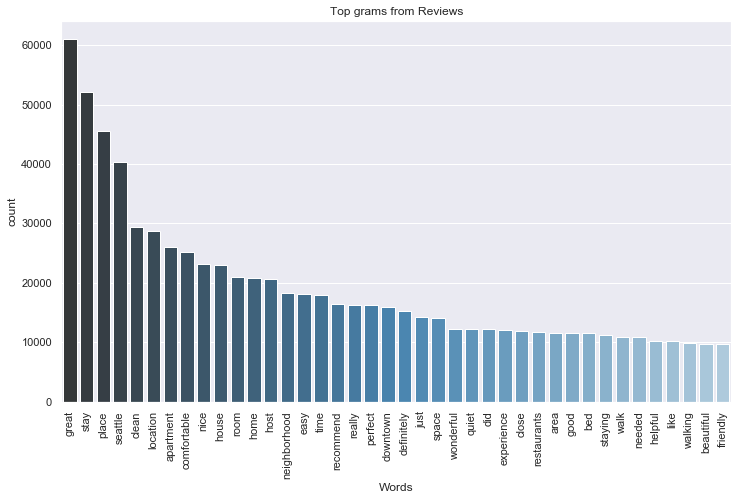

In [26]:
plot_gram(uni_grams)

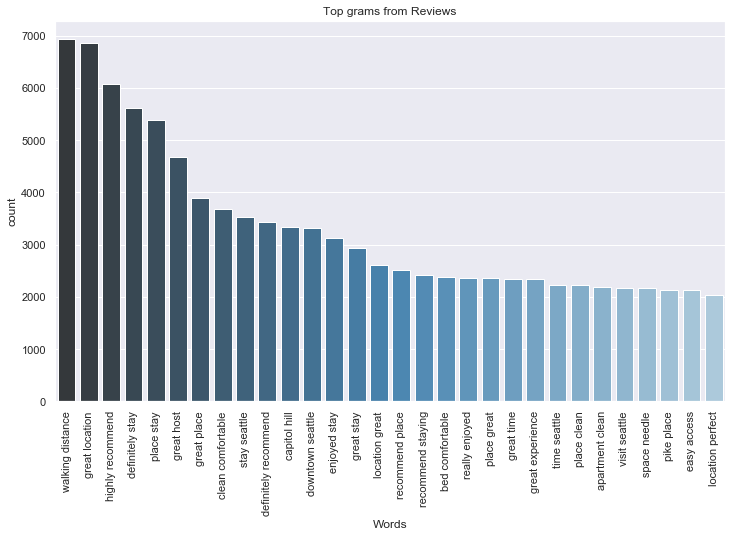

In [27]:
plot_gram(bi_grams)

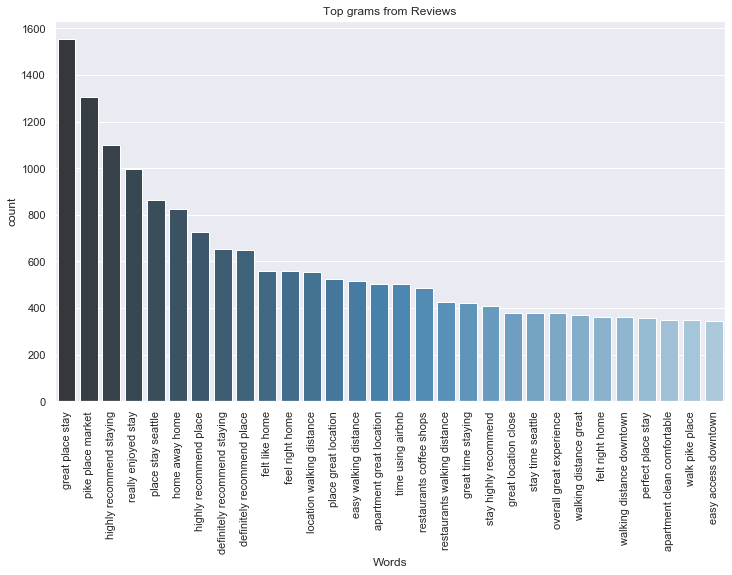

In [28]:
plot_gram(tri_grams)

## Cleaning the data for Tableau 

In [32]:
raw_data = pd.read_csv('airbnb_bi_project_nyc_homes_rawdata.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
# retrieve columns that raised a warning
#As shown above in red

[raw_data.columns.values[x] for x in [43,87,88]] 

['zipcode', 'license', 'jurisdiction_names']

In [34]:
raw_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50220 entries, 0 to 50219
Data columns (total 96 columns):
id                                  50220 non-null int64
listing_url                         50220 non-null object
scrape_id                           50220 non-null int64
last_scraped                        50220 non-null int64
name                                50195 non-null object
summary                             48360 non-null object
space                               34428 non-null object
description                         49793 non-null object
experiences_offered                 50220 non-null object
neighborhood_overview               29794 non-null object
notes                               19829 non-null object
transit                             31136 non-null object
access                              29056 non-null object
interaction                         27817 non-null object
house_rules                         29928 non-null object
thumbnail_url           

In [36]:
raw_data.head(5) 

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2515,https://www.airbnb.com/rooms/2515,20180908060534,43351,Stay at Chez Chic budget room #1,Step into our artistic spacious apartment and ...,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,Step into our artistic spacious apartment and ...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,1.41
1,2539,https://www.airbnb.com/rooms/2539,20180908060534,43351,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,NaN,NaN,f,f,moderate,f,f,8,0.24
2,2595,https://www.airbnb.com/rooms/2595,20180908060534,43351,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,2,0.32
3,3330,https://www.airbnb.com/rooms/3330,20180908060534,43351,++ Brooklyn Penthouse Guestroom ++,"This is a spacious, clean, furnished master be...","Room Features: - clean, hardwood floors - 2 la...","This is a spacious, clean, furnished master be...",none,Location is GREAT!! Right off the L train in t...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,0.31
4,3647,https://www.airbnb.com/rooms/3647,20180908060534,43351,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,NaN


In [37]:
#ISNA denotes missing values - showing all columns
raw_data.isna().sum()[raw_data.isna().sum() != 0]

name                              25
summary                         1860
space                          15792
description                      427
neighborhood_overview          20426
notes                          30391
transit                        19084
access                         21164
interaction                    22403
house_rules                    20292
thumbnail_url                  50220
medium_url                     50220
xl_picture_url                 50220
host_name                          8
host_since                         8
host_location                    156
host_about                     19688
host_response_time             16735
host_response_rate             16735
host_acceptance_rate           50220
host_is_superhost                  8
host_thumbnail_url                 8
host_picture_url                   8
host_neighbourhood              7103
host_listings_count                8
host_total_listings_count          8
host_has_profile_pic               8
h

In [38]:
#Out of 96 we retirve 21 columns we will use 
#for analysis and feature engineering

data = raw_data[[
'host_id',
'host_since',
'host_is_superhost',
'neighbourhood_cleansed','neighbourhood_group_cleansed',
'zipcode',
'latitude','longitude',
'room_type',
'bathrooms','bedrooms','beds',
'price','weekly_price','monthly_price',
'security_deposit',
'cleaning_fee',
'number_of_reviews','review_scores_rating','reviews_per_month',
]].copy().reset_index() 

#Updating for use in Tableau 
data = data.rename(columns={'index':'id', 
                            'host_is_superhost':'superhost', 
                            'neighbourhood_cleansed':'neighborhood', 
                            'neighbourhood_group_cleansed': 'city'})


In [39]:
#for understanding data types and their usage once imported into Tableau 
data.dtypes 

id                        int64
host_id                   int64
host_since              float64
superhost                object
neighborhood             object
city                     object
zipcode                  object
latitude                float64
longitude               float64
room_type                object
bathrooms               float64
bedrooms                float64
beds                    float64
price                     int64
weekly_price            float64
monthly_price           float64
security_deposit        float64
cleaning_fee            float64
number_of_reviews         int64
review_scores_rating    float64
reviews_per_month       float64
dtype: object

In [40]:
data.zipcode = pd.to_numeric(data.zipcode, errors='coerce',
                             downcast='integer') 
# changing zipcode to numeric. 

In [41]:
data.isna().sum()[data.isna().sum() != 0] 

host_since                  8
superhost                   8
zipcode                   721
bathrooms                 102
bedrooms                   57
beds                       69
weekly_price            42897
monthly_price           43821
security_deposit        19527
cleaning_fee            12381
review_scores_rating    11900
reviews_per_month       10790
dtype: int64

In [42]:
data = data.dropna(subset=['host_since','superhost','zipcode']) 

In [27]:
#data.to_csv('airbnb_bi_project_nyc_cleaneddata.csv', encoding='utf-8', sep=',', index=False) 

## Subsetting the 180 MB file

In [15]:
#creating a subset of the 180MB raw data
raw_data = pd.read_csv('airbnb_bi_project_nyc_homes_rawdata.csv')
raw_data = raw_data.iloc[0:10]

In [16]:
raw_data

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2515,https://www.airbnb.com/rooms/2515,20180908060534,43351,Stay at Chez Chic budget room #1,Step into our artistic spacious apartment and ...,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,Step into our artistic spacious apartment and ...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,1.41
1,2539,https://www.airbnb.com/rooms/2539,20180908060534,43351,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,NaN,NaN,f,f,moderate,f,f,8,0.24
2,2595,https://www.airbnb.com/rooms/2595,20180908060534,43351,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,2,0.32
3,3330,https://www.airbnb.com/rooms/3330,20180908060534,43351,++ Brooklyn Penthouse Guestroom ++,"This is a spacious, clean, furnished master be...","Room Features: - clean, hardwood floors - 2 la...","This is a spacious, clean, furnished master be...",none,Location is GREAT!! Right off the L train in t...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,0.31
4,3647,https://www.airbnb.com/rooms/3647,20180908060534,43351,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,NaN
5,3831,https://www.airbnb.com/rooms/3831,20180908060534,43351,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,NaN,NaN,f,f,moderate,f,f,1,4.40
6,4484,https://www.airbnb.com/rooms/4484,20180908060534,43351,DowntownRoom,"My place is close to Katz's Delicatessen, Stat...","Rent the second bedroom in my cozy, friendly a...","My place is close to Katz's Delicatessen, Stat...",none,NaN,...,f,NaN,NaN,f,f,moderate,f,f,1,0.53
7,5022,https://www.airbnb.com/rooms/5022,20180908060534,43351,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,0.09
8,5099,https://www.airbnb.com/rooms/5099,20180908060534,43351,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment is true New York ...,none,My neighborhood in Midtown East is called Murr...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,0.57
9,5121,https://www.airbnb.com/rooms/5121,20180908060534,43351,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.45


In [17]:
raw_data.to_csv('airbnb_bi_project_nyc_rawdata_sample.csv', encoding='utf-8', sep=',', index=False) 